In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

## Load data

In [2]:
meta = pd.read_excel('C:/Users/lan/Documents/repos/inter/mat/adp_dataset_suite2p_compare.xlsx', index_col=None)
meta = meta[['mouse','date','area']]
meta.loc[1, 'date'] = '200803_py_subpil'
meta

,mouse,date,area
0,1322,200803,V1
1,1322,200803_py_subpil,V1


In [4]:
nset = len(meta.index); ncell = []; nori = 8; nisi = 3; nframe_trial = 223
dir_name = 'C:\\Users\\lan\\Documents\\repos\\inter\\mat\\'

vis_ad = np.empty([0,1]); vis_tg = np.empty([0,1]); well_fit = np.empty([0,1])
ori_pref = np.empty([0,nisi]); fit_param = np.empty([0,7,nisi])
dfof_ad = np.empty([0,1]); dfof_tg = np.empty([0,nori,nisi])
dfof_ad_std = np.empty([0,1]); dfof_tg_std = np.empty([0,nori,nisi])
trace = np.empty([0,nori,nisi,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'cell_property_loose' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    fit_tuning = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'fit_tuning_isi3' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['vis_cell_ad']), axis=0)
    vis_tg = np.concatenate((vis_tg, cell_prop['vis_cell_noad_tg']), axis=0)
#     well_fit = np.concatenate((well_fit, cell_prop['well_fit_cell']), axis=0)
    
    ori_pref = np.concatenate((ori_pref, cell_prop['ori_pref']), axis=0)
    fit_param = np.concatenate((fit_param, fit_tuning['fit_param']), axis=0)

    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nisi,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            for iisi in np.arange(nisi):
                trace_flat[icell][iori][iisi][:] = trace_align['trace_avg'][icell][iori][iisi].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, vis_ad.shape, vis_tg.shape#, well_fit.shape, ori_pref.shape, fit_param.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([97, 1153], (1250, 1), (1250, 1))

In [5]:
meta['ncell'] = ncell
meta.loc[1, 'area'] = 'V1_py'
meta
# meta = meta.replace({'area' : { 'V1':1, 'LM':2, 'LI':3 }})
# meta

,mouse,date,area,ncell
0,1322,200803,V1,97
1,1322,200803_py_subpil,V1_py,1153


In [7]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell

,mouse,area
0,1322,V1
1,1322,V1
2,1322,V1
3,1322,V1
4,1322,V1
...,...,...
1245,1322,V1_py
1246,1322,V1_py
1247,1322,V1_py
1248,1322,V1_py


### Cell property percentage

In [9]:
df_well_fit = meta_cell.copy()
# df_well_fit['well_fit'] = well_fit
df_well_fit.groupby('area').describe()

mouse                                                     
        count    mean  std     min     25%     50%     75%     max
area                                                              
V1       97.0  1322.0  0.0  1322.0  1322.0  1322.0  1322.0  1322.0
V1_py  1153.0  1322.0  0.0  1322.0  1322.0  1322.0  1322.0  1322.0

In [7]:
tt = df_well_fit[df_well_fit.well_fit == 1]
tt.groupby('area').describe()

mouse                                                      well_fit  \
      count    mean  std     min     25%     50%     75%     max    count   
area                                                                        
V1     54.0  1322.0  0.0  1322.0  1322.0  1322.0  1322.0  1322.0     54.0   
V1_py  72.0  1322.0  0.0  1322.0  1322.0  1322.0  1322.0  1322.0     72.0   

                                          
      mean  std  min  25%  50%  75%  max  
area                                      
V1     1.0  0.0  1.0  1.0  1.0  1.0  1.0  
V1_py  1.0  0.0  1.0  1.0  1.0  1.0  1.0

## Adaptation magnitude

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [10]:
adp_mag = dfof_tg[:,0,[1,2]] / dfof_ad - 1

meta_cell_750 = meta_cell.copy(); meta_cell_750['isi'] = 750
meta_cell_250 = meta_cell.copy(); meta_cell_250['isi'] = 250
meta_cell_isi = pd.concat([meta_cell_750, meta_cell_250], ignore_index=True)

df_adp_mag = meta_cell_isi.copy()
df_adp_mag['adp_mag'] = adp_mag.flatten('F')
df_adp_mag['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)

df_adp_mag['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_mag = df_adp_mag[ df_adp_mag['vis_ad'] == 1 ]
df_adp_mag.reset_index()

,index,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,0,1322,V1,750,-0.239962,0.083296,1.0
1,1,1322,V1,750,-0.267440,0.079051,1.0
2,2,1322,V1,750,0.092123,0.089755,1.0
3,3,1322,V1,750,-0.258139,0.149961,1.0
4,4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...,...
1857,2495,1322,V1_py,250,-0.280770,0.132144,1.0
1858,2496,1322,V1_py,250,-0.363514,0.376105,1.0
1859,2497,1322,V1_py,250,-0.107988,0.252071,1.0
1860,2498,1322,V1_py,250,-0.600701,0.126928,1.0


In [11]:
df_adp_mag[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
            count      mean       std       min       25%       50%       75%   
area  isi                                                                       
V1    750    89.0 -0.219988  0.425581 -1.453907 -0.408103 -0.200769  0.004951   
      250    89.0 -0.223430  0.466281 -1.725731 -0.480220 -0.249909 -0.023923   
V1_py 750   842.0 -0.227870  0.745376 -3.113052 -0.603344 -0.248705  0.148951   
      250   842.0 -0.103300  0.885994 -3.225168 -0.569448 -0.188072  0.297543   

                     
                max  
area  isi            
V1    750  0.935566  
      250  1.183066  
V1_py 750  2.955118  
      250  8.697882

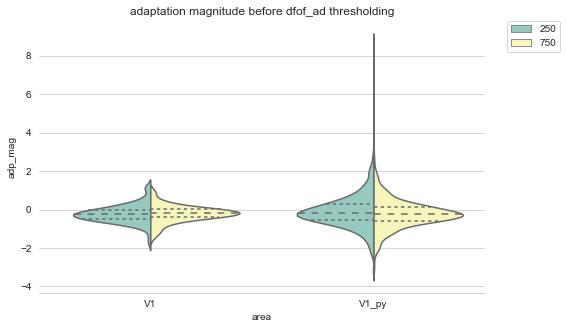

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax = sns.violinplot(data=df_adp_mag, x="area", y="adp_mag", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(title = 'adaptation magnitude before dfof_ad thresholding')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### add dfof_ad thresholding

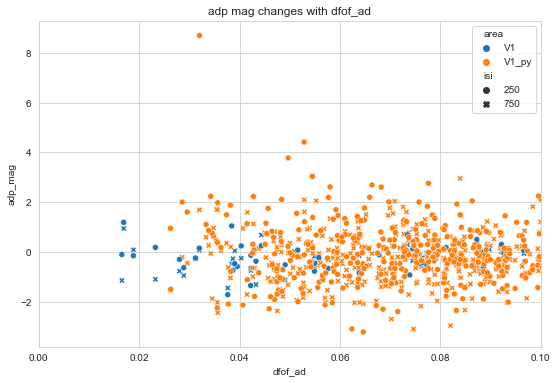

In [13]:
plt.figure(figsize=(9,6))
ax = sns.scatterplot(data=df_adp_mag, x="dfof_ad", y="adp_mag", hue="area", style="isi")
# plt.xlim([0,0.8]);
plt.xlim([0,0.1]);
ax.set(title = 'adp mag changes with dfof_ad');

In [14]:
df = df_adp_mag.sort_values(by=['dfof_ad'])
df1 = df[df.isi == 750]
df2 = df[df.isi == 250]

def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling mean')
    plt.title('adp mag rolling mean change with dfof_ad of cells')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

In [15]:
def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling std')
    plt.title('adp mag rolling std change with dfof_ad of cells')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

In [16]:
df_adp_mag

,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,1322,V1,750,-0.239962,0.083296,1.0
1,1322,V1,750,-0.267440,0.079051,1.0
2,1322,V1,750,0.092123,0.089755,1.0
3,1322,V1,750,-0.258139,0.149961,1.0
4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...
2495,1322,V1_py,250,-0.280770,0.132144,1.0
2496,1322,V1_py,250,-0.363514,0.376105,1.0
2497,1322,V1_py,250,-0.107988,0.252071,1.0
2498,1322,V1_py,250,-0.600701,0.126928,1.0


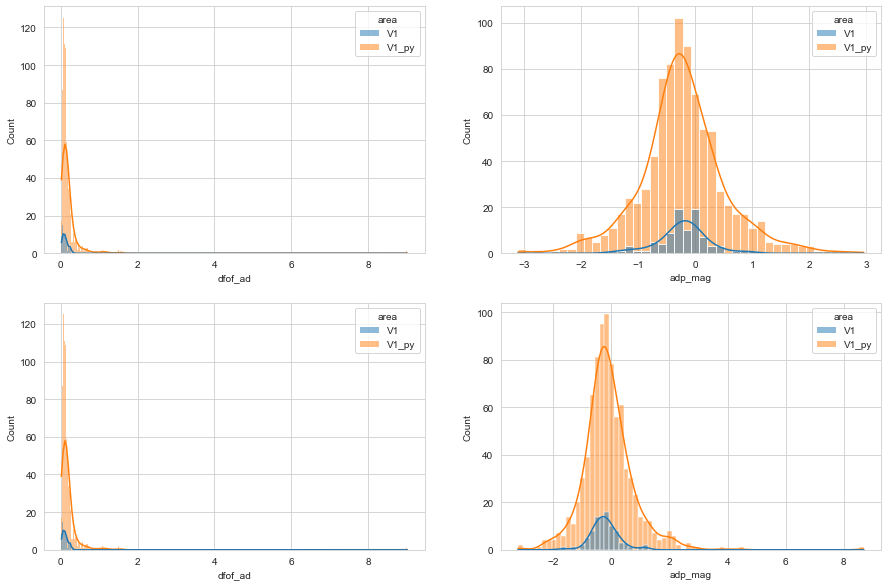

In [17]:
plt.figure(figsize=(15,10));
plt.subplot(221)
sns.histplot(data=df_adp_mag[df_adp_mag.isi == 750], x="dfof_ad", hue="area", kde=True)
plt.subplot(222)
sns.histplot(data=df_adp_mag[df_adp_mag.isi == 750], x="adp_mag", hue="area", kde=True)
plt.subplot(223)
sns.histplot(data=df_adp_mag[df_adp_mag.isi == 250], x="dfof_ad", hue="area", kde=True)
plt.subplot(224)
sns.histplot(data=df_adp_mag[df_adp_mag.isi == 250], x="adp_mag", hue="area", kde=True)

cell selection: vis_ad only, with dfof_ad thresholding

In [18]:
dfof_threshold = 0.05 # 0.03
df_adp_mag_thres = df_adp_mag[df_adp_mag.dfof_ad >= dfof_threshold]
df_adp_mag_thres.reset_index();

In [19]:
df_adp_mag_thres[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
            count      mean       std       min       25%       50%       75%   
area  isi                                                                       
V1    750    70.0 -0.144975  0.304050 -0.885213 -0.337381 -0.151284 -0.005519   
      250    70.0 -0.221106  0.390055 -0.953823 -0.465775 -0.243462 -0.025890   
V1_py 750   787.0 -0.222793  0.717743 -3.113052 -0.585269 -0.251544  0.137150   
      250   787.0 -0.123476  0.777482 -3.225168 -0.556082 -0.192867  0.258431   

                     
                max  
area  isi            
V1    750  0.919585  
      250  1.149798  
V1_py 750  2.955118  
      250  4.411132

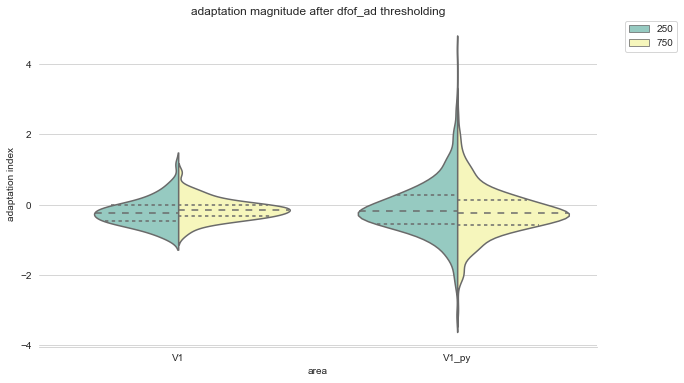

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.violinplot(data=df_adp_mag_thres, x="area", y="adp_mag", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(ylabel = 'adaptation index', title = 'adaptation magnitude after dfof_ad thresholding');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [657]:
tt

,area,isi,adp_mag
0,1,750,-0.188318
1,2,750,-0.076079
2,3,750,-0.270519
3,1,250,-0.399921
4,2,250,-0.686542
5,3,250,-0.971112


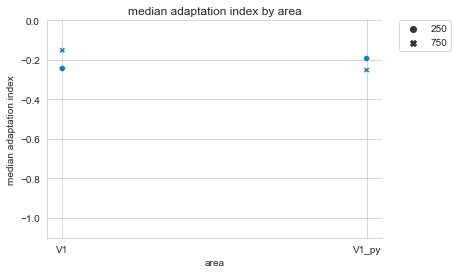

In [21]:
t = df_adp_mag_thres.copy()
tt = t[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).median().reset_index()

ax = sns.scatterplot(data=tt, x="area", y="adp_mag", style="isi"); sns.despine()
ax.set(ylabel = 'median adaptation index', title = 'median adaptation index by area')
plt.ylim([-1.1,0])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Adaptation tuning bias

In [22]:
tt = ori_pref.copy()
tt[tt > 90] = np.abs(tt[tt > 90] - 180)
tuning_bias = tt[:,[1,2]] - tt[:,[0]];

ori_pref_bin = tt[:,[0]];
ori_pref_bin[ori_pref_bin < 22.5] = 0; ori_pref_bin[ori_pref_bin > 67.5] = 90; 
ori_pref_bin[(ori_pref_bin >= 22.5) & (ori_pref_bin <= 67.5)] = 45; 

In [28]:
df_adp_tune = meta_cell_isi.copy()
df_adp_tune['tuning_bias'] = tuning_bias.flatten('F')
df_adp_tune['ori_pref_bin'] = np.concatenate((ori_pref_bin, ori_pref_bin), axis=0)

df_adp_tune['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_tune['well_fit'] = np.concatenate((well_fit, well_fit), axis=0)
df_adp_tune = df_adp_tune[ df_adp_tune['vis_ad'] == 1 ]
df_adp_tune = df_adp_tune[ df_adp_tune['well_fit'] == 1 ]

b, c = df_adp_tune.iloc[0].copy(), df_adp_tune.iloc[1].copy() 
df_adp_tune.iloc[0], df_adp_tune.iloc[1] = c, b # swap row 0 & 1 to sort df.gb properly
df_adp_tune.reset_index()

,index,mouse,area,isi,tuning_bias,ori_pref_bin,vis_ad,well_fit
0,0,1322,V1,750,12.444471,0.0,1.0,1.0
1,2,1322,V1,750,12.848284,45.0,1.0,1.0
2,3,1322,V1,750,3.611104,45.0,1.0,1.0
3,4,1322,V1,750,7.906208,45.0,1.0,1.0
4,5,1322,V1,750,-8.242688,90.0,1.0,1.0
...,...,...,...,...,...,...,...,...
233,1996,1322,V1_py,250,6.352155,0.0,1.0,1.0
234,2050,1322,V1_py,250,10.583073,0.0,1.0,1.0
235,2104,1322,V1_py,250,6.022670,45.0,1.0,1.0
236,2147,1322,V1_py,250,5.252723,45.0,1.0,1.0


In [29]:
df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).describe()

tuning_bias                                   \
                             count       mean        std        min   
area  isi ori_pref_bin                                                
V1    750 0.0                 14.0   4.237129   7.620755  -5.315182   
          45.0                30.0   2.981489   7.227020 -15.553142   
          90.0                 3.0  -9.225393   8.335961 -18.009150   
      250 0.0                 14.0   1.857337   4.603939  -6.714045   
          45.0                30.0  -2.411950   8.961618 -33.241919   
          90.0                 3.0  -5.399939   6.490821 -10.462322   
V1_py 750 0.0                 20.0  12.380400   9.491875  -7.572441   
          45.0                48.0   8.069886  10.901641 -14.255961   
          90.0                 4.0  -7.648601  13.042526 -21.515716   
      250 0.0                 20.0   7.711008   7.775619  -5.615133   
          45.0                48.0   2.719732   8.953192 -15.562213   
          90.0                 4.0 -10.572254  11.521881 -22.764059   

                                                                    
                              25%        50%        75%        max  
area  isi ori_pref_bin                                              
V1    750 0.0           -1.856112   3.324932   8.814326  22.372315  
          45.0          -0.571052   3.799186   8.926861  12.848284  
          90.0         -13.125919  -8.242688  -4.833515  -1.424341  
      250 0.0           -0.846012   2.326327   4.496529   9.510487  
          45.0          -6.775953  -0.042094   2.614331  11.071087  
          90.0          -9.058753  -7.655183  -2.868747   1.917688  
V1_py 750 0.0            5.649856  16.771778  18.981520  27.684480  
          45.0           1.991290   8.586735  13.244796  34.504417  
          90.0         -13.476329  -9.487657  -3.659929   9.896627  
      250 0.0            3.210260   6.534778  11.914546  22.951653  
          45.0          -2.188122   3.256615   6.591427  31.952141  
          90.0         -16.121038 -12.198005  -6.649221   4.871053

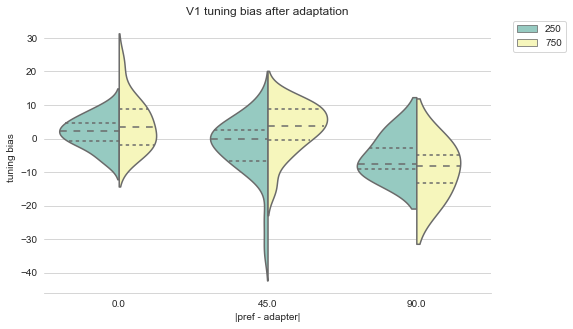

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax = sns.violinplot(data=df_adp_tune[df_adp_tune.area == 'V1'], 
                    x="ori_pref_bin", y="tuning_bias", hue="isi", 
                    split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(xlabel = '|pref - adapter|', ylabel = 'tuning bias', title = 'V1 tuning bias after adaptation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

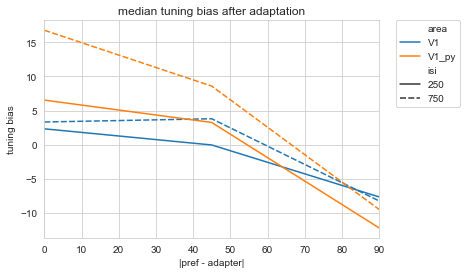

In [31]:
tt = df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).median().reset_index()

ax = sns.lineplot(data=tt, x="ori_pref_bin", y="tuning_bias", hue="area", style="isi");
ax.set(xlabel = '|pref - adapter|', ylabel = 'tuning bias', title = 'median tuning bias after adaptation')
plt.xlim([0,90])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Misc
### Adaptation increases variability (?)
for ori=0 target after adaptation, fano factor is higher than adapter  
cell selection: vis_ad only, with thresholding of dfof_ad & dfof_tg0

In [32]:
adp_fano_tg = dfof_tg_std[:,0,[1,2]] / dfof_tg[:,0,[1,2]]
adp_fano_ad = dfof_ad_std / dfof_ad
adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_tg + adp_fano_ad) # range [-1,1], meaning fano factor de/increase after adp
# adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_ad)

df_adp_fano = meta_cell_isi.copy()
df_adp_fano['adp_fano'] = adp_fano.flatten('F')
df_adp_fano['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)
df_adp_fano['dfof_tg'] = np.concatenate((dfof_tg[:,0,1], dfof_tg[:,0,2]), axis=0)

df_adp_fano['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_fano = df_adp_fano[ df_adp_fano['vis_ad'] == 1 ]

df_adp_fano = df_adp_fano[(df_adp_fano.dfof_ad >= dfof_threshold) & (df_adp_fano.dfof_tg >= dfof_threshold)]
df_adp_fano.reset_index()

,index,mouse,area,isi,adp_fano,dfof_ad,dfof_tg,vis_ad
0,0,1322,V1,750,0.198528,0.083296,0.063308,1.0
1,1,1322,V1,750,0.249547,0.079051,0.057910,1.0
2,2,1322,V1,750,0.224684,0.089755,0.098024,1.0
3,3,1322,V1,750,0.069735,0.149961,0.111251,1.0
4,4,1322,V1,750,0.079733,0.242218,0.230214,1.0
...,...,...,...,...,...,...,...,...
2033,2489,1322,V1_py,250,0.205993,0.128877,0.106924,1.0
2034,2490,1322,V1_py,250,0.261484,0.228478,0.167853,1.0
2035,2491,1322,V1_py,250,0.203939,0.208646,0.182107,1.0
2036,2492,1322,V1_py,250,0.438674,0.124743,0.078732,1.0


In [33]:
df_adp_fano[['adp_fano','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_fano                                                    \
             count      mean       std       min       25%       50%   
area  isi                                                              
V1    750     61.0  0.107590  0.131371 -0.221762  0.055359  0.117452   
      250     56.0  0.096801  0.126978 -0.184001  0.009455  0.110434   
V1_py 750    926.0  0.118435  0.120498 -0.311766  0.036897  0.125030   
      250    995.0  0.197022  0.118755 -0.419078  0.124784  0.202259   

                               
                75%       max  
area  isi                      
V1    750  0.192632  0.396914  
      250  0.186146  0.408596  
V1_py 750  0.198302  0.492126  
      250  0.273186  0.553499

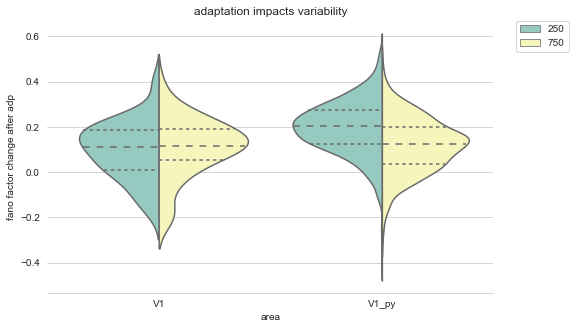

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax = sns.violinplot(data=df_adp_fano, x="area", y="adp_fano", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(ylabel = 'fano factor change after adp', title = 'adaptation impacts variability')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);